=============================================================================================================================================

customizaed BO algo for customized problem - PHASE I - PC PRETRAINING

- full observation
- partial data usage
- offline Optimization
- [x] simulated imbalanced Dataset
- [x] imbalanced evaluation (two classes)
- [x] punish no / bonus yes . when precision and recall are all above 0.9, times a bonus factor, say, 1.1
- static data set and proxy model
- assumption: the a priori of the data distribution is not far away from the real data distribution

=============================================================================================================================================

## Dependencies

In [1]:
# COMMON
import numpy as np
import sys
import os
import random
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Excitation
import ambient_vibration
import earthquake
import impact
import strongwind

# Strcutural Modeling
import model_build

# Response Calculation
import newmark_beta

# Triggering Mechanism
import triggering as trig

# Signal Processing
from scipy import signal  # for signal processing
from scipy.signal import hilbert  # for signal processing
import prenn # for deep learning

# AI
import keras

import tensorflow as tf # for deep learning
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import TensorBoard # for visualization

import onnxruntime as ort # for onnx runtime

# Visualization
# %matplotlib qt5
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

## The System Related Contents

### Dataset

In [2]:
# Data Path
AVPath = 'E:/OneDrive - Nanyang Technological University/3_Research/02-SATM/SATM-DATA/PYTHON-GEN-DATA-USE/RESPONSE_AV.npy'
EQPath = 'E:/OneDrive - Nanyang Technological University/3_Research/02-SATM/SATM-DATA/PYTHON-GEN-DATA-USE/RESPONSE_EQ.npy'
IPPath = 'E:/OneDrive - Nanyang Technological University/3_Research/02-SATM/SATM-DATA/PYTHON-GEN-DATA-USE/RESPONSE_IP.npy'
SWPath = 'E:/OneDrive - Nanyang Technological University/3_Research/02-SATM/SATM-DATA/PYTHON-GEN-DATA-USE/RESPONSE_SW.npy'

# Load Data
RESPONSE_AV = np.load(AVPath)
RESPONSE_EQ = np.load(EQPath)
RESPONSE_IP = np.load(IPPath)
RESPONSE_SW = np.load(SWPath)

## only use part of the data
raw_len_av = RESPONSE_AV.shape[0]
raw_len_eq = RESPONSE_EQ.shape[0]
raw_len_ip = RESPONSE_IP.shape[0]
raw_len_sw = RESPONSE_SW.shape[0]

# this is to simulate the imbalanced data
ratio_aw = 0.15
ratio_eq = 0.05
ratio_ip = 0.05
ratio_sw = 0.05

uselen_aw = int(raw_len_av * ratio_aw)
uselen_eq = int(raw_len_eq * ratio_eq)  
uselen_ip = int(raw_len_ip * ratio_ip)
uselen_sw = int(raw_len_sw * ratio_sw)

# randomly pick uselen_aw samples from RESPONSE_XX, no repeat
idx_aw = random.sample(range(raw_len_av), uselen_aw)
idx_eq = random.sample(range(raw_len_eq), uselen_eq)
idx_ip = random.sample(range(raw_len_ip), uselen_ip)
idx_sw = random.sample(range(raw_len_sw), uselen_sw)

RESPONSE_AV = RESPONSE_AV[idx_aw]
RESPONSE_EQ = RESPONSE_EQ[idx_eq]
RESPONSE_IP = RESPONSE_IP[idx_ip]
RESPONSE_SW = RESPONSE_SW[idx_sw]

## Check Data Info
print(type(RESPONSE_AV))
print('RESPONSE_AV Shape:', RESPONSE_AV.shape)
print(type(RESPONSE_EQ))
print('RESPONSE_EQ Shape:', RESPONSE_EQ.shape)
print(type(RESPONSE_IP))
print('RESPONSE_IP Shape:', RESPONSE_IP.shape)
print(type(RESPONSE_SW))
print('RESPONSE_SW Shape:', RESPONSE_SW.shape)

num_type = 4

nDOF = RESPONSE_AV.shape[1]

reshape_av_0 = RESPONSE_AV.shape[0] * nDOF
reshape_eq_0 = RESPONSE_EQ.shape[0] * nDOF
reshape_ip_0 = RESPONSE_IP.shape[0] * nDOF
reshape_sw_0 = RESPONSE_SW.shape[0] * nDOF

signal_length = RESPONSE_AV.shape[2]

reshape_av_1 = signal_length
reshape_eq_1 = signal_length
reshape_ip_1 = signal_length
reshape_sw_1 = signal_length

LenTS = signal_length

# Integrate All Data into a 2D Array

## Reshape Data
RESPONSE_AV_RESHAPED = RESPONSE_AV.reshape(reshape_av_0, reshape_av_1)
RESPONSE_EQ_RESHAPED = RESPONSE_EQ.reshape(reshape_eq_0, reshape_eq_1)
RESPONSE_IP_RESHAPED = RESPONSE_IP.reshape(reshape_ip_0, reshape_ip_1)
RESPONSE_SW_RESHAPED = RESPONSE_SW.reshape(reshape_sw_0, reshape_sw_1)

## Check Data Info
print(type(RESPONSE_AV_RESHAPED))
print('RESPONSE_AV Shape:', RESPONSE_AV_RESHAPED.shape)
print(type(RESPONSE_EQ_RESHAPED))
print('RESPONSE_EQ Shape:', RESPONSE_EQ_RESHAPED.shape)
print(type(RESPONSE_IP_RESHAPED))
print('RESPONSE_IP Shape:', RESPONSE_IP_RESHAPED.shape)
print(type(RESPONSE_SW_RESHAPED))
print('RESPONSE_SW Shape:', RESPONSE_SW_RESHAPED.shape)

# ratio of non-interested data to interested data
ratio_ni = RESPONSE_AV_RESHAPED.shape[0] / (RESPONSE_EQ_RESHAPED.shape[0] + RESPONSE_IP_RESHAPED.shape[0] + RESPONSE_SW_RESHAPED.shape[0])

print('Ratio of Non-Interested Data to Interested Data:', ratio_ni)

## Stack Data
RESPONSE = np.vstack((RESPONSE_AV_RESHAPED, RESPONSE_EQ_RESHAPED, RESPONSE_IP_RESHAPED, RESPONSE_SW_RESHAPED))

## Total Number of Samples
NumSample = RESPONSE.shape[0]
print('Total Number of Samples:', NumSample) 

<class 'numpy.ndarray'>
RESPONSE_AV Shape: (150, 5, 6000)
<class 'numpy.ndarray'>
RESPONSE_EQ Shape: (50, 5, 6000)
<class 'numpy.ndarray'>
RESPONSE_IP Shape: (50, 5, 6000)
<class 'numpy.ndarray'>
RESPONSE_SW Shape: (50, 5, 6000)
<class 'numpy.ndarray'>
RESPONSE_AV Shape: (750, 6000)
<class 'numpy.ndarray'>
RESPONSE_EQ Shape: (250, 6000)
<class 'numpy.ndarray'>
RESPONSE_IP Shape: (250, 6000)
<class 'numpy.ndarray'>
RESPONSE_SW Shape: (250, 6000)
Ratio of Non-Interested Data to Interested Data: 1.0
Total Number of Samples: 1500


In [3]:
# USED PARAMETER of the Dataset

# nn_in_len = 128 # nn input length can be automatically calculated from the model input size
dt = 0.01  # time step, change according to the dataset
nperseg = 128 # number of points for each segment in spectrogram

### Classifier Model

In [4]:
# MODEL PATH
model_path = "cnn_model.keras"
model = keras.saving.load_model(model_path)

# summary of the model
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 4)         │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 4)         │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 4)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142 (572.00 B)

 Trainable params: 44 (176.00 B)

 Non-trainable params: 8 (32.00 B)

 Optimizer params: 90 (364.00 B)

In [5]:
# get the input data length
nn_in_len = model.input_shape[1]
print('Input Data Length:', nn_in_len)

Input Data Length: 128


Test Data Shape: (1, 6000)


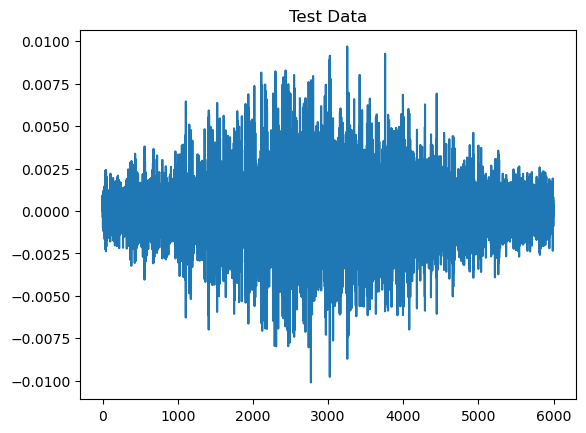

In [6]:
# model test by loading a piece of data from the dataset, and feed intot he prenn function

# index for the random data
idx = np.random.randint(NumSample)

# get the data
test_data = RESPONSE[idx, :].reshape(1, LenTS)

print('Test Data Shape:', test_data.shape)

# plot the test data
plt.figure()
plt.plot(test_data[0, :])
plt.title('Test Data')
plt.show()


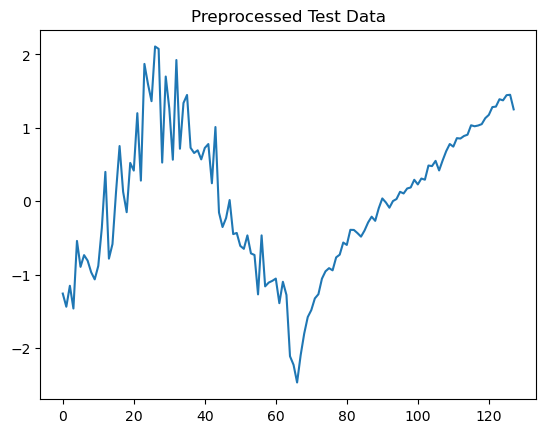

In [7]:
# preprocess
output_length = nn_in_len
test_data = prenn.prenn(test_data, dt, nperseg, output_length)

# print the preprocessed data
plt.figure()
plt.plot(test_data[0, :])
plt.title('Preprocessed Test Data')
plt.show()

In [8]:
test_data = test_data.reshape(1, nn_in_len, 1)

print('Preprocessed Test Data Shape:', test_data.shape)

# test the model
test_result = model.predict(test_data)
print('Tensorflow Model Prediction:', test_result)

# parse the result to get the label
result_label = np.argmax(test_result)

print('Tensorflow Model Prediction:', result_label)

Preprocessed Test Data Shape: (1, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Tensorflow Model Prediction: [[1.5401789e-06 1.2233309e-03 1.6371972e-05 9.9875879e-01]]
Tensorflow Model Prediction: 3


### Triggering Mechanism

In [9]:
# load noise to determine the search space
noise_sample = RESPONSE[0, :].reshape(1, LenTS)

# max noise
max_noise = np.max(abs(noise_sample))

# min noise
min_noise = np.min(abs(noise_sample))

# scale factor for threshold range upper bound
ub_factor = 5

# scale factor for threshold range lower bound
lb_factor = 0.01

In [10]:
# configuration
para_a_lb = lb_factor*(max_noise + min_noise)/2
para_a_ub = ub_factor*(max_noise + min_noise)/2
para_b_lb = 2
para_b_ub = 20

beta = 1.75 # beta value to balance the precision and recall

In [11]:
print('para_a_ub', para_a_ub)

para_a_ub 0.005970621119811317


In [12]:
# triggering mechanism
para_a = 10
para_b = 2

In [13]:
# shape of test data
print('Shape of Test Data:', test_data.shape)

Shape of Test Data: (1, 128, 1)


In [14]:
# # squeeze the data
# test_data = np.squeeze(test_data)

# # shape of test data
# print('Shape of Test Data:', test_data.shape)

In [15]:
trig_flg = trig.activation(test_data, para_a, para_b)
print(trig_flg[0])

0


## Bayesian Optimization Framework

### Helpers

In [16]:
# use pop-up window for plots
%matplotlib qt5 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
# print control
from colorama import init, Fore, Back, Style

In [17]:
# CONFIGURABLE PARAMETERS

## Hyperparameters
noise_lvl = 0.1
k_alpha = 1
k_lambda = 1

## Process Control
num_init_points = 30
num_iter = 20
tolerance = 1e-3
gap = np.inf

## Acquisition Function - UCB
ucb_beta = 0.25

## Acquisition Function - PI & EI
xi=0.01


## Bonus factor for evaluation
bonus_factor = 1.1

In [18]:
## Search Space
### parameter 1 - a
lb_a = para_a_lb
ub_a = para_a_ub
c_a = (ub_a + lb_a) / 2
print(c_a)

### parameter 2 - b
lb_b = para_b_lb
ub_b = para_b_ub
c_b = (ub_b + lb_b) / 2
print(c_b)

0.00299128118102547
11.0


### The Problem / System to Optimize

Triggering Mechanism： Triggering Parameters In; Evaluation Index Out

In [19]:
# THE OBJECTIVE FUNCTION
def objective_function(para_a, para_b):

    """ Function with unknown internals we wish to maximize.

    This function defines the process to evaluate how good the parameters are for the triggering sensing mechanism.

    INPUT:
    - para_a: the threshold for the activation, positive real number
    - para_b: activate_duration: the duration for the activation, positive integer >= 2 (as we know 1 is not error-prone in practice)

    OUTPUT:
    - evaluation value: F-beta score
    
    HYPERPARAMETERS:
    - beta: the value to balance the precision and recall to calculate F-beta score
    
    """
    
    # assistive variables
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    
    # go through the dataset
    for i in range(NumSample):
    # for i in range(10):  
        # trigger flag
        flg_trigger = 0
        
        # ground truth flag
        class_1h = np.zeros((1, num_type))
        flg_class = 0
        flg_interst = 0
        
        # get the response data
        signal = RESPONSE[i, :].reshape(1, LenTS)
        
        # get the triggering mechanism
        flg_trigger, trig_pos = trig.activation(signal, para_a, para_b)
        
        # print('Trigger Flag:', flg_trigger)
        
        # preprocess the signal for the CNN model to get the ground truth
        signal = prenn.prenn(signal, dt, nperseg, nn_in_len)
        
        signal = signal.reshape(1, nn_in_len, 1)

        # get the ground truth
        class_1h = model.predict(signal, verbose=0)
        flag_class = np.argmax(class_1h)
        
        # get the ground truth
        if flag_class > 0:
            flg_interst = 1

        # get the confusion matrix - as the number of interested data is assumed to be small, we need to consider the ratio - only two classes - interested and non-interested
        if flg_trigger == 1 and flg_interst == 1:
            TP += 1*ratio_ni
        elif flg_trigger == 1 and flg_interst == 0:
            FP += 1
        elif flg_trigger == 0 and flg_interst == 1:
            FN += 1*ratio_ni
        elif flg_trigger == 0 and flg_interst == 0:
            TN += 1
        else:
            print('Error in Confusion Matrix Calculation')
            
    # demoninator
    denominator = ((1 + beta**2) * TP + beta**2 * FN + FP)
    if denominator == 0:
        F_beta = 0
        return 0
    
    F_beta = (1 + beta**2) * TP / ((1 + beta**2) * TP + beta**2 * FN + FP)
    
    # if F_beta is NaN, return 0
    if np.isnan(F_beta):
        F_beta = 0
        return 0
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    if precision > 0.9 and recall > 0.9:
        F_beta = F_beta * bonus_factor
    
    # print TP, FP, FN, TN as integer, Precision, Recall, F-beta as float number with 4 decimal places
    print('para_a / para_b /TP / FP / FN / TN / Precision / Recall / F-beta:', para_a, para_b, TP, FP, FN, TN, f'{precision:.4f}', f'{recall:.4f}', f'{F_beta:.4f}')

    return F_beta


In [20]:
# THE SURROGATE MODEL - Gaussian Process - Kernel Function
## Matern 2.5 as the kernel function
def kernel(p1, p2, matern_alpha = 1, matern_lambda = 1):
    # define the distance between two points p1 and p2
    d= np.linalg.norm(p1 - p2)
    k = matern_alpha * (1 + np.sqrt(5) * d / matern_lambda + 5 * d**2 / (3 * matern_lambda**2)) * np.exp(-np.sqrt(5) * d / matern_lambda)
    return k

## Mean and Variance of the Gaussian Process
def mean_var(x, D, K_alpha, k_lambda):
    # assume x is a variable of 1x1
    # calculate the mean and variance of the Gaussian Process
    x_dim = x.shape[1] # assume each colum is a dimension of x
    num_D = D.shape[0] # number of data points in D
    
    Ktt = np.zeros((num_D, num_D))
    for i in range(num_D):
        for j in range(num_D):
            Ktt[i, j] = kernel(D[i,:-1], D[j,:-1], K_alpha, k_lambda)
    Kttn = Ktt + np.eye(num_D) * noise_lvl
    IKttn = np.linalg.inv(Kttn)
    
    Kpt = np.zeros((1, num_D))
    for i in range(num_D):
        Kpt[0, i] = kernel(x, D[i,:-1], K_alpha, k_lambda)
    Ktp = Kpt.T
    Kpp = kernel(x, x, K_alpha, k_lambda)
    
    y = D[:,-1].reshape(-1,1)
    
    mean = Kpt @ IKttn @ y
    var = Kpp - Kpt @ IKttn @ Ktp
        
    return mean, var

In [21]:
# THE ACQUISITION FUNCTION - UPPER CONFIDENCE BOUND
def S(x, D):
    mean, var = mean_var(x, D, k_alpha, k_lambda)
    s = mean + ucb_beta * np.sqrt(var)
    return s

In [22]:
def norm_cdf(x):
    """
    standard normal cumulative distribution function
    
    """
    return 0.5 * (1 + np.math.erf(x / np.sqrt(2)))

In [23]:
def norm_pdf(x):
    """
    standard normal probability density function
    """
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x ** 2)

In [24]:
# THE ACQUISITION FUNCTION - PROBABILITY OF IMPROVEMENT
def S_PI(x, D, xi=0.01):
    f_best = np.max(D[:,-1])
    mean, var = mean_var(x, D, k_alpha, k_lambda)
    z = (mean - f_best - xi) / np.sqrt(var)
    s = norm_cdf(z)
    return s

In [25]:
# THE ACQUISITION FUNCTION - EXPECTATION OF IMPROVEMENT
def S_EI(x, D, xi=0.01):
    f_best = np.max(D[:,-1])
    mean, var = mean_var(x, D, k_alpha, k_lambda)
    z = (mean - f_best - xi) / np.sqrt(var)
    s = (mean - f_best - xi) * norm_cdf(z) + np.sqrt(var) * norm_pdf(z)
    return s

In [26]:
# THE OPTIMIZATION FUNCTION FOR THE ACQUISITION FUNCTION
def optimize_acquisition(D):
    # randomly search for the point with the highest acquisition function value
    num_search = 100
    max_s = -np.inf
    max_x = None
    cur_x = np.zeros((1,2))
    for i in range(num_search):
        cur_x[0,0] = np.random.uniform(lb_a, ub_a)
        cur_x[0,1] = np.random.uniform(lb_b, ub_b)
        cur_s = S(cur_x, D) # UCB
        # cur_s = S_PI(cur_x, D, xi) # PI
        # cur_s = S_EI(cur_x, D, xi) # EI
        if cur_s > max_s:
            max_s = cur_s
            max_x = cur_x.copy()
    return max_x

### The Optimization Process

In [27]:
# PHASE 1 - INITIAL DATASET
D = np.zeros((num_init_points, 3)) # first column is a, second column is b, third column is the objective function value
for i in range(num_init_points):
    a = np.random.uniform(lb_a, ub_a)
    b = np.random.uniform(lb_b, ub_b)
    D[i, 0] = a
    D[i, 1] = b
    D[i, 2] = objective_function(a, b)
    # print progress
    print('Initialization Progress:', i+1, '/', num_init_points)

para_a / para_b /TP / FP / FN / TN / Precision / Recall / F-beta: 0.0026247385991527692 7.603848494725042 695.0 134 58.0 613 0.8384 0.9230 0.9006
Initialization Progress: 1 / 30
para_a / para_b /TP / FP / FN / TN / Precision / Recall / F-beta: 0.003894106436676328 3.970462754264897 699.0 75 54.0 672 0.9031 0.9283 1.0142
Initialization Progress: 2 / 30
para_a / para_b /TP / FP / FN / TN / Precision / Recall / F-beta: 0.0010262063516745406 10.33502571777573 753.0 747 0 0 0.5020 1.0000 0.8037
Initialization Progress: 3 / 30
para_a / para_b /TP / FP / FN / TN / Precision / Recall / F-beta: 0.0010381155793191975 9.971746843005082 753.0 747 0 0 0.5020 1.0000 0.8037
Initialization Progress: 4 / 30
para_a / para_b /TP / FP / FN / TN / Precision / Recall / F-beta: 0.002090697893266576 19.228673877704622 540.0 5 213.0 742 0.9908 0.7171 0.7694
Initialization Progress: 5 / 30
para_a / para_b /TP / FP / FN / TN / Precision / Recall / F-beta: 0.004931152248765908 11.851356665181083 502.0 0 251.0 747

In [28]:
max_val = np.max(D[:,2])
print('Initial Maximum Value:', max_val)

Initial Maximum Value: 1.0141535277287392


In [29]:
# PHASE 2 - OPTIMIZATION ITERATIONS
for i in range(num_iter):
    
    update_flg = False
    
    # (1) use the surrogate model to approach the posterior distribution of the objective function, modeled by Gaussian Process which can be characterized by the mean function and the covariance function
    
    ## mean, var = mean_var(x, D, 1, 1)
    
    # (2) determine the next point to evaluate using the acquisition function S(D)
    x_eval = optimize_acquisition(D)
    
    # (3) evaluate the objective function at the next point
    f_eval = objective_function(x_eval[0,0], x_eval[0,1])
    
    # (4) update the dataset D
    newpoint = np.zeros((1,3))
    newpoint[0,0] = x_eval[0,0]
    newpoint[0,1] = x_eval[0,1]
    newpoint[0,2] = f_eval
    D = np.vstack((D, newpoint))
    
    # # (5) check the stopping criterion
    # gap = np.abs(D[-1, -1] - D[-2, -1])
    # if gap < tolerance:
    #     break
    
    # (5) update the global best value
    if f_eval > max_val:
        max_val = f_eval
        max_x = x_eval
        update_flg = True
    
    # (6) print the progress
    if (update_flg == True):
        print('BO Iteration:', i+1,'/', num_iter, 'Best Value Updated:', max_val, 'at', max_x)
    else:
        print('BO Iteration:', i+1,'/', num_iter)
    
    # (7) reset the flag
    update_flg = False
    

para_a / para_b /TP / FP / FN / TN / Precision / Recall / F-beta: 0.003999655081567509 2.9406574551666473 699.0 142 54.0 605 0.8312 0.9283 0.9023
BO Iteration: 1 / 20
para_a / para_b /TP / FP / FN / TN / Precision / Recall / F-beta: 0.004213865310370788 3.322690570073039 688.0 30 65.0 717 0.9582 0.9137 1.0167
BO Iteration: 2 / 20 Best Value Updated: 1.0166787227446523 at [[0.00421387 3.32269057]]
para_a / para_b /TP / FP / FN / TN / Precision / Recall / F-beta: 0.003403775103580318 3.4262971456191256 702.0 210 51.0 537 0.7697 0.9323 0.8862
BO Iteration: 3 / 20
para_a / para_b /TP / FP / FN / TN / Precision / Recall / F-beta: 0.004998645966199639 2.9633244221833497 683.0 1 70.0 746 0.9985 0.9070 1.0208
BO Iteration: 4 / 20 Best Value Updated: 1.0207667063815558 at [[0.00499865 2.96332442]]
para_a / para_b /TP / FP / FN / TN / Precision / Recall / F-beta: 0.005866954086097572 3.0234132156896623 637.0 0 116.0 747 1.0000 0.8459 0.8793
BO Iteration: 5 / 20
para_a / para_b /TP / FP / FN / TN

In [30]:
# number of points in D
print(D.shape[0])

50


In [31]:
# VISUALIZATION
# plot the final dataset in animation, mark the order of the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('threshold')
ax.set_ylabel('duration')
ax.set_zlabel('F-beta score')
ax.set_xlim(0, 1.1*ub_a)
ax.set_ylim(0, 1.1*ub_b)
ax.set_zlim(0, bonus_factor)

def update(i):
    ax.scatter(D[:i, 0], D[:i, 1], D[:i, 2], c='b')
    ax.text(D[i, 0], D[i, 1], D[i, 2], str(i), color='black')
    return ax

ani = FuncAnimation(fig, update, frames=D.shape[0], repeat=False)

plt.show()

In [38]:
# Visualization
# stem plot

# Assuming D is already defined and contains your data
# D[:, 0] -> threshold
# D[:, 1] -> duration
# D[:, 2] -> F-beta score

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('threshold')
ax.set_ylabel('duration')
ax.set_zlabel('F-beta score')
ax.set_xlim(0, 1.1*ub_a)
ax.set_ylim(0, 1.1*ub_b)
ax.set_zlim(0, bonus_factor)

# Create stem plot
for i in range(D.shape[0]):
    x = D[i, 0]
    y = D[i, 1]
    z = D[i, 2]
    ax.plot([x, x], [y, y], [0, z], 'k--')
    ax.scatter(x, y, z, c='b', marker='o')
    ax.text(x, y, z, str(i), color='black')

plt.show()


In [32]:
# print the final value
print(D[-1, -1])

# print the max value
print(np.max(D[:, -1]))

# print the argmax
print(D[np.argmax(D[:, -1]), :-1])

# print the row index of the max value
print(np.argmax(D[:, -1]))

0.8924046903541335
1.0212388284587917
[0.00458083 2.87551377]
48


In [33]:
# save lb_a, ub_a, lb_b, ub_b, noise_lvl, k_alpha, k_lambda, num_init_points, num_iter, tolerance, ucb_beta
np.save('config.npy', np.array([lb_a, ub_a, lb_b, ub_b, noise_lvl, k_alpha, k_lambda, num_init_points, num_iter, tolerance, ucb_beta]))

# save D to a file
np.save('D.npy', D)